This file will be used to train the policies and use them to generate the trajectories. 

Let's start by creating the environment we will be using: Cartpool

In [146]:
%load_ext autoreload
%autoreload 2
%aimport -numpy
%aimport -torch
%aimport -gym

import gym as gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
torch.manual_seed(0)

# for saving/loading
import os

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [148]:
env = gym.make('CartPole-v0')
env.seed(0)


C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is mar

[0]

For the definition of classes and functions for training the policies, refer to train_policy_func.py file 

In [149]:
## Define the policy network

from Train_policy_func import Policy, Policy_v2, device
from Generate_traj_func import generate_trajectory

policy = Policy_v2(state_size=env.observation_space.shape[0], action_size=env.action_space.n).to(device)

# Generate one trajectory for testing: 
traj = generate_trajectory(policy, env)
print(f"Episode length: {len(traj)}, Total reward: {sum(s['reward'] for s in traj)}")

Episode length: 15, Total reward: 15.0


C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


## cell to save hyperparameters effciency history: A quest to successfully master PPO
### Hyperparameters
env_name     = "CartPole-v0"
policy       = Policy
updates      = 500        # how many times to run rollout+update, thus how many updates on the policy
actor_length = 4          # number of actors to run (in parallel if possible) per update
traj_length  = 200        # per actor
c1           = 0.5        # value loss coefficient
c2           = 0.01       # entropy coefficient, if not decaying. If so, check below
clip_eps     = 0.2        # PPO clipping parameter
gamma, lam   = 0.99, 0.95 # GAE parameters
lr           = 0.003
batch_size   = 64
epochs       = 4
results = 46.65
time = 4min

actor length = 8
resutls = 46.86 
time = 8min 43

actor length = 4
traj_length = 600
results = 48.25
time = 14 min

traj_length = 200
c1 = c2 = 0
results = 36.42
time = 4 min 37

c1 = 0.5; c2 = 0.01
lr = 0.01
results = 46.26
time = 4 min 34

lr = 0.003
updates = 1000
results = 52.21
time = 9 min 26 

updates = 500
policy = Policy_v2
results = 43.59
time = 4 min 54

adding evaluation run during training

c2 = 0
results = 42
time = 5 min 43

c2 = 0.1
results = 34.84
time = 6 min 22

c2 = 0.01
c1 = 0
result = 36.62
time = 6 min 14

c1 = 0.5
lr = 0.0003
result = 55 
time = 5 min 55 !

batch_size = 128
result = 37
time = 5 min 20

batch_size = 64
epochs = 8
result = 58 
time = 6 min 24 !

epochs = 8
gamma = 1
return = 50
time = 6min 30

gamma = 0.9
results = 61
time = 6 min 37 !

gamma = 0.8
result = 100
time = 6 min 30 ! 

updates = 250 (no improvement after)
gamma = 0.7
result = 58
time = 3 min 30

gamma = 0.75
result = 62
time = 3min7

gamma = 0.85
result = 55 (pi2 85)
time = 3 min 16

gamma = 0.8
result = 57
time = 3 min 10

updates = 500
gamma = 0.75

In [ ]:
# Training loop for PPO 

from PPO import ppo_update, RolloutBuffer, evaluate_policy

# "In practice you’ll often tune these three carefully":
# clip_eps in [0.1, 0.3]
# lam in [0.90, 0.98]
# lr in [1e-5, 1e-3]"

# # Hyperparameters
# env_name     = "CartPole-v0"
# updates      = 25       # how many times to run rollout+update, thus how many updates on the policy
# actor_length = 8         # number of actors to run (in parallel if possible) per update
# traj_length  = 2048        # per actor
# c1           = 0.5        # value loss coefficient
# c2           = 0.01      # entropy coefficient, if not decaying. If so, check below
# clip_eps     = 0.2        # PPO clipping parameter
# gamma, lam   = 0.99, 0.95 # GAE parameters
# lr           = 0.001659
# batch_size   = 64
# epochs       = 4

# From Hyperspace.ipynb:
updates = 25
actor_length = 8
traj_length = 2048
c1 = 0.1822
c2 = 0.0377
clip_eps = 0.1
gamma, lam = 0.9157, 0.8329
lr = 0.0016595613641357258
batch_size = 47
epochs = 4


# decaying entropy coefficient
entropy_coef_start = 0.01
entropy_coef_end   = 1e-4      # 0 or a small floor like 1e-4
max_updates = updates 

# Instantiate
env       = gym.make(env_name)
env.seed(0)
policy    = Policy_v2().to(device)
optimizer = optim.Adam(policy.parameters(), lr=lr)
PPO_reward_per_update = []
buffer = RolloutBuffer()

eval_every = 50 # every how many updates to evaluate the policy
eval_curve   = []

for update in tqdm(range(updates)):
    buffer.clear() # clear the buffer for the next batch of trajectories
    avg_returns = []
    actor_rewards     = []

    # 1) Collect trajectories
    for N in range(actor_length):
        state = env.reset() 
        steps = 0

        # for tracking episode returns within this batch
        current_ep_reward   = 0.0
        reward_per_actor = []
        
        # 1.1 one trajectory per actor
        while steps < traj_length or done == False:
            action, logp, value = policy.act(state)
            next_state, reward, done, _ = env.step(action)
            buffer.store(state, action, logp, reward, value, done)
            state = next_state
            steps += 1


            # accumulate for this episode
            current_ep_reward += reward

            if done:
                actor_rewards.append(current_ep_reward)
                current_ep_reward = 0.0
                state = env.reset() 
                # break

        # if not done:      
            # # force a “done” so GAE stops here
            # buffer.dones[-1] = True

        # # in case the last episode didn’t terminate exactly on traj_length
        # if current_ep_reward > 0.0:
        #     actor_rewards.append(current_ep_reward)

        # compute average return for this batch
        avg_ret = np.mean(actor_rewards)
        avg_returns.append(avg_ret)

    if update % eval_every == 0:
        mean_eval, _ = evaluate_policy(policy, env, n_episodes=20)
        eval_curve.append((update, mean_eval))
        print(f"[Update {update}] Eval return: {mean_eval:.1f}")


    PPO_reward_per_update.append(np.mean(actor_rewards))

    # # 2) Compute last value (for GAE)     -> done in ppo_update ? I think so
    # _, last_value = policy(torch.from_numpy(state).float().unsqueeze(0).to(device))

    # 2.5) Linear-decay schedule:
    # frac = 1.0 - (update - 1) / float(max_updates)
    # c2 = entropy_coef_end + frac * (entropy_coef_start - entropy_coef_end)

    half = max_updates // 2
    if update <= half:
        c2 = entropy_coef_start * (1.0 - (update - 1) / half)
    else:
        c2 = 0.0


    # 3) PPO update
    ppo_update(policy, optimizer, buffer,gamma,lam,c1, c2, clip_eps, epochs, batch_size)

    # 4) Saving checkpoint of the policy to get pi2
    if (update ) % 20 == 0 : # and update < updates/2
        print(f"Update {update}/{updates} completed. Average return: {np.mean(actor_rewards)}")
        # save the policy
        torch.save(policy.state_dict(), f"pi2_checkpoint_{update}.pth")

# 5) at the end, save pi1
torch.save(policy.state_dict(), "pi1_final.pth")
print("Saved final policy as pi1_final.pth")



  0%|          | 0/25 [00:00<?, ?it/s]

[Update 0] Eval return: 21.5


  4%|▍         | 1/25 [00:10<04:18, 10.76s/it]

Update 0/25 completed. Average return: 21.524869109947645


 84%|████████▍ | 21/25 [04:02<00:49, 12.47s/it]

Update 20/25 completed. Average return: 46.717514124293785


100%|██████████| 25/25 [04:46<00:00, 11.46s/it]

Saved final policy as pi1_final.pth


In [151]:
# ## Generate preference pairs

# # Load π₂ (weak) and π₁ (strong)
# from pairs_generator import sample_preference_pairs

pi2 = Policy_v2().to(device)
pi2.load_state_dict(torch.load("pi2_checkpoint_20.pth"))
pi2.eval()

pi1 = Policy_v2().to(device)
pi1.load_state_dict(torch.load("pi1_final.pth"))
pi1.eval()

# # Generate one trajectory each to inspect
# traj1 = generate_trajectory(pi1, env, max_steps=1000)
# traj2 = generate_trajectory(pi2, env, max_steps=1000)

# print(f"π₁ → length {len(traj1)}, total reward {sum(s['reward'] for s in traj1):.1f}")
# print(f"π₂ → length {len(traj2)}, total reward {sum(s['reward'] for s in traj2):.1f}")

# prefs = sample_preference_pairs(pi1, pi2, env, K=200) # Need to define K elsewhere as hyperparameter
# print(f"Collected {len(prefs)} preference pairs.")


C:\Users\turin\AppData\Local\Temp\ipykernel_158956\2584541204.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi2.load_state_dict(torch.load("pi2_checkpoint_20.pth"))
C:

Policy_v2(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (v): Linear(in_features=64, out_features=1, bias=True)
  (act1): Tanh()
)

In [152]:
## Visulization of the policies and trajectories
# %autoreload 2
from Generate_traj_func import plot_suboptimality, plot_trajectory_performance


num_episodes = 100
pi1_mean_reward, pi1_reward = evaluate_policy(pi1, env, n_episodes=num_episodes)
pi2_mean_reward, pi2_reward = evaluate_policy(pi2, env, n_episodes=num_episodes)


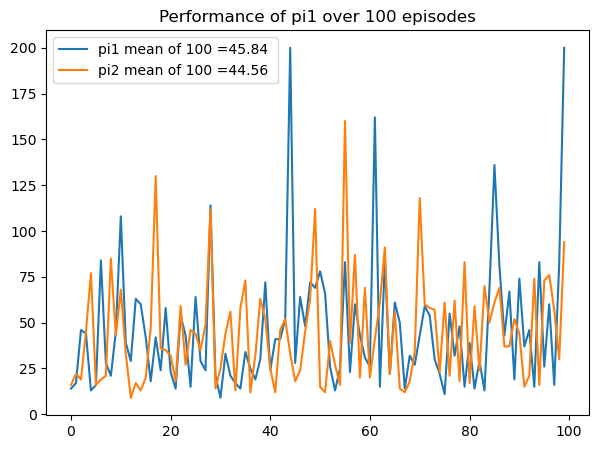

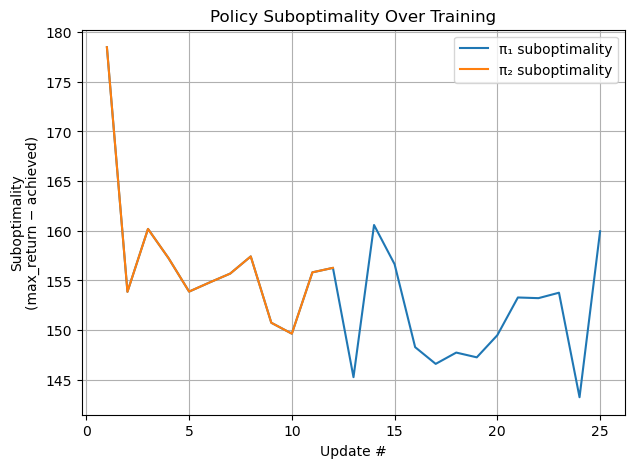

In [153]:
plt.figure(figsize=(7, 5)) 
plt.plot(np.arange(len(pi1_reward)), pi1_reward, label=f"pi1 mean of 100 ={pi1_mean_reward} ")
plt.plot(np.arange(len(pi2_reward)), pi2_reward, label=f"pi2 mean of 100 ={pi2_mean_reward} ")
plt.title("Performance of pi1 over 100 episodes" )
plt.legend()

plot_suboptimality(
    PPO_reward_per_update,
    PPO_reward_per_update[0 : int(len(PPO_reward_per_update) / 2)],
    200,
)  # in cartpole, 200 is the maximum reward
# plot_trajectory_performance(traj1, traj2)
# print(f" size traj1: {len(traj1)}, size traj2: {len(traj2)}")

In [154]:
# # Training loop for OPPO
# from OPPO import baseline_1, OPPO_update
# from Train_policy_func import Policy, device

# lr_oppo = 0.01

# # ── Re-instantiate a fresh policy & optimizer for OPPO ──
# env_oppo   = gym.make(env_name)
# policy_oppo = Policy(state_size=env_oppo.observation_space.shape[0],
#                      action_size=env_oppo.action_space.n).to(device)
# opt_oppo    = torch.optim.Adam(policy_oppo.parameters(), lr=lr_oppo)

# # ── Hyperparams for OPPO ──
# n_episodes = 1200      # keep same “number of iterations” for fair comparison
# max_t      = 200  # cap on steps per episode
# print_every=100

# # ── Run the OPPO training ──
# scores_oppo = OPPO_update(
#     policy       = policy_oppo,
#     optimizer    = opt_oppo,
#     env          = env_oppo,
#     baseline     = baseline_1,
#     n_episodes   = n_episodes,
#     max_t        = max_t,
#     gamma        = gamma,      # you can reuse your PPO γ
#     print_every  = print_every,
#     early_stop   = False
# )

# # ── Post-processing: smooth or average returns per “block” if you like
# avg_scores_oppo = [
#     np.mean(scores_oppo[i : i + print_every])
#     for i in range(0, len(scores_oppo), print_every)
# ]




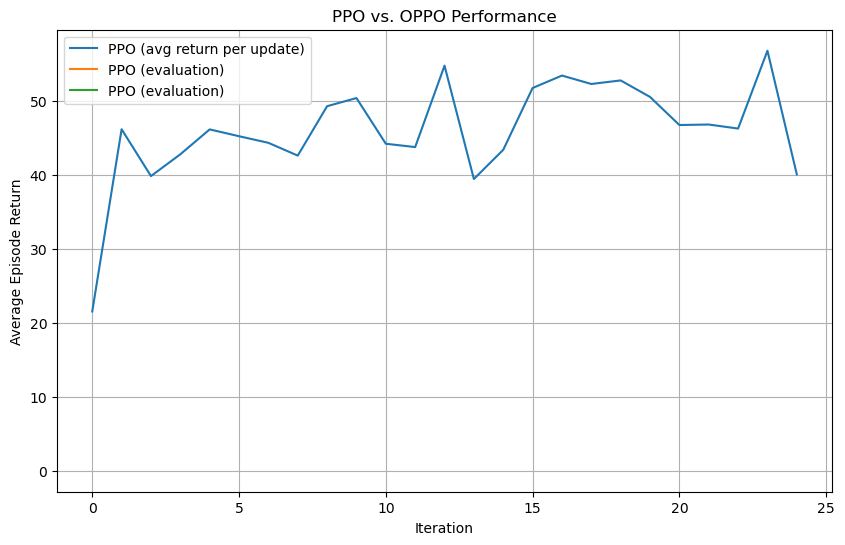

In [155]:

plt.figure(figsize=(10, 6)) 
plt.plot(
    np.arange(len(PPO_reward_per_update)), PPO_reward_per_update,
    label="PPO (avg return per update)"
)
plt.plot(
    np.arange(len(eval_curve)), eval_curve,
    label="PPO (evaluation)",
)
# plt.plot(
#     100*np.arange(len(avg_scores_oppo)), avg_scores_oppo,
#     label=f"OPPO (avg return per {print_every} eps)"
# )
# plt.plot(
#     np.arange(len(scores_oppo)), scores_oppo,
#     label=f"OPPO (score)"
# )

plt.xlabel("Iteration")
plt.ylabel("Average Episode Return")
plt.legend()
plt.grid(True)
plt.title("PPO vs. OPPO Performance")
plt.show()